In [ ]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import ward, fcluster, leaders
from scipy.cluster import hierarchy
from scipy.sparse import csr_matrix
import csv
import networkx as nx
import seaborn as sns
import math
import concurrent.futures
from networkx.algorithms.community.quality import modularity
from sklearn.metrics import silhouette_score

sc = StandardScaler()

sns.set_style("ticks")


sns.despine()
sim_seg = 1.1

<Figure size 432x288 with 0 Axes>

In [3]:
influenceFile = "./data/source_data/influence_data.csv"
artistFile = "./data/source_data/data_by_artist.csv"

influenceData = pd.read_csv(influenceFile)
artistData = pd.read_csv(artistFile)



In [4]:
genre = {0: 'Avant-Garde', 1: 'Blues', 2: "Children's", 3: 'Classical', 4: 'Comedy/Spoken', 5: 'Country', 6: 'Easy Listening', 7: 'Electronic', 8: 'Folk', 9: 'International', 10: 'Jazz', 11: 'Latin', 12: 'New Age', 13: 'Pop/Rock', 14: 'R&B;', 15: 'Reggae', 16: 'Religious', 17: 'Stage & Screen', 18: 'Vocal'}


In [5]:
genre_res = pd.DataFrame(index=artistData.index, columns=['genre'])

'''
for row_index, row in influenceData['influencer_id'].items():
    _tem = (influenceData.loc[(influenceData['influencer_id'] == row) ]['influencer_main_genre'])
    if _tem.shape[0] != 0:
        genre_res['genre'][row_index] = _tem.iloc[0]

for row_index, row in influenceData['follower_id'].items():
    _tem = (influenceData.loc[(influenceData['follower_id'] == row)]['follower_main_genre'])
    if _tem.shape[0] != 0:
        genre_res['genre'][row_index] = _tem.iloc[0]
    print(genre_res)
'''
for row_index, row in artistData['artist_id'].items():
    _tem = (influenceData.loc[(influenceData['influencer_id'] == row) | (influenceData['follower_id'] == row)]['influencer_main_genre'])
    if _tem.shape[0] != 0:
        genre_res['genre'][row_index] = _tem.iloc[0]

artistData_concated = pd.concat([artistData,genre_res],axis=1)

artistData_concated.to_csv('./res/artistData_concated1.csv')



In [6]:
# 去重 去unmaned 去nan

def cleanData(data):
    cleaned_data = data.drop_duplicates(keep='first',inplace=False).loc[:, ~data.columns.str.contains("^Unnamed")].dropna(axis=1,how='all').dropna(axis=0, how='any')
    return cleaned_data

In [7]:
GenresFile = "./res/artistData_concated1.csv"
artistData = pd.read_csv(GenresFile)
artistData = cleanData(artistData)
grouped_data = artistData.groupby('genre').apply(lambda x:x.iloc[:,2:14].mean(axis=0))
print(grouped_data)
grouped_data.to_csv('./data/our_data/19data.csv')


    

                danceability    energy   valence       tempo   loudness  \
genre                                                                     
Avant-Garde         0.436896  0.286897  0.390137  110.131905 -18.412089   
Blues               0.580006  0.489710  0.636353  119.021334 -11.426346   
Children's          0.709574  0.525775  0.655679  119.085558  -9.301703   
Classical           0.341915  0.217280  0.231986  106.600625 -20.872188   
Comedy/Spoken       0.544984  0.616603  0.483116  109.716178 -12.366414   
Country             0.576746  0.524306  0.608996  121.759615 -10.015144   
Easy Listening      0.440047  0.397162  0.414997  112.190047 -13.392766   
Electronic          0.620994  0.660154  0.481286  120.389864  -9.704865   
Folk                0.510696  0.322905  0.491096  117.297610 -14.066014   
International       0.550272  0.462553  0.580582  114.563118 -12.122737   
Jazz                0.528073  0.384972  0.516795  113.589848 -14.172628   
Latin               0.612

In [8]:
def cos_sim(vector_a, vector_b):
    """
    计算两个向量之间的余弦相似度
    :param vector_a: 向量 a
    :param vector_b: 向量 b
    :return: sim
    """
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 1 + 0.5 * cos
    return sim

In [99]:
def o_sim(x1,x2):
  distance=np.linalg.norm(x1-x2)
  return 1/(1+distance)

In [100]:
def make_global_distance(x1,x2):
    return cos_sim(x1,x2)/1.5+o_sim(x1,x2)

In [9]:
def sil_score(G):
    from sklearn.metrics import silhouette_score

    # 将节点按所属社团划分
    node2community = {node: community_id for community_id, community in enumerate(nx.connected_components(G)) for node in community}

    # 获取每个节点的特征向量
    node_features = {artist_ids[i]: artistData_np[i] for i in range(len(artist_ids))}

    # 将特征向量和所属社团转换为 X 和 y
    X = np.array([node_features[node] for node in G.nodes()])
    y = np.array([node2community[node] for node in G.nodes()])

    # 计算轮廓系数
    silhouette_avg = silhouette_score(X, y)

    print(f"平均轮廓系数为 {silhouette_avg}")
    return silhouette_avg

def sil_score1(G,labels):
    # 将图G转化为二元矩阵
    adjacency_matrix = nx.to_numpy_array(G)
    
    # 计算轮廓系数
    silhouette_avg = silhouette_score(adjacency_matrix, labels)
    
    print(f"平均轮廓系数为 {silhouette_avg}")
    
    return silhouette_avg









In [10]:
from sklearn.preprocessing import StandardScaler
data = pd.read_csv('./data/our_data/19data.csv')
to_normalize = data.columns[1:13]
scaler = StandardScaler()

# 对列数据进行归一化
data[to_normalize] = scaler.fit_transform(data[to_normalize])

# 将归一化后的数据写入csv文件
data.to_csv('./data/our_data/normalized_genre_data.csv', index=False)

genres_to_keep = ['Country', 'Blues', 'Avant-Garde', "Children's", 'Classical', 'Comedy/Spoken', 'Easy Listening', 'Electronic', 'Folk', 'International', 'Jazz', 'Latin', 'New Age', 'Pop/Rock', 'R&B;', 'Reggae', 'Religious', 'Stage & Screen', 'Vocal']
artistData = artistData[artistData['genre'].isin(genres_to_keep)]
print(artistData)
to_normalize = artistData.columns[3:14]
scaler = StandardScaler()
artistData[to_normalize] = scaler.fit_transform(artistData[to_normalize])
#print(artistData)
artistData.to_csv('./data/our_data/normalized_artist_data.csv', index=False)

             artist_name  artist_id  danceability    energy   valence  \
0          Frank Sinatra     792507      0.384478  0.238017  0.364288   
2            Johnny Cash     816890      0.619803  0.449381  0.680662   
3         Billie Holiday      79016      0.572637  0.201368  0.498934   
4              Bob Dylan      66915      0.512598  0.477932  0.551934   
5     The Rolling Stones     894465      0.524446  0.719915  0.655332   
...                  ...        ...           ...       ...       ...   
5849     Natalie La Rose    3359519      0.830000  0.520000  0.735000   
5850          Sarah Ross    3381566      0.721000  0.944000  0.626000   
5851              Rotimi    3410250      0.637000  0.501000  0.431000   
5852  Jillian Jacqueline    3455945      0.547000  0.672000  0.283000   
5853         Jaira Burns    3639618      0.566000  0.769000  0.385000   

           tempo   loudness  mode  key  acousticness  instrumentalness  \
0     110.181698 -14.271141     1    5      0.735

In [11]:
def get_artist_names_and_ids(artistData):
    id_to_name = {}
    name_to_id = {}
    artist_ids = []
    artist_names = []
    genres = []

    # 将 artistData 转换为字典
    artist_dict = artistData.to_dict('records')

    # 遍历 artist_dict，将 artist_id 和 artist_name 添加到 artist_ids 和 artist_names 列表中
    for i, artist in enumerate(artist_dict):
        artist_id = i
        artist_name = artist['artist_name']
        genre = artist['genre']
        artist_ids.append(artist_id)
        artist_names.append(artist_name)
        genres.append(genre)
        id_to_name[artist_id] = artist_name
        name_to_id[artist_name] = artist_id

    return id_to_name, name_to_id, artist_ids, artist_names, genres




In [104]:
'''
artistData_np = artistData.drop(columns=['artist_name', 'artist_id', 'count', 'popularity', 'genre']).to_numpy().astype(float)
GenresFile = "./data/our_data/normalized_artist_data.csv"
genreData = pd.read_csv(GenresFile)
#genreData_np = genreData.drop(columns=['genre']).to_numpy().astype(float)


#print(genreData_np[0])
max_indices = np.apply_along_axis(lambda x: np.argmax(np.apply_along_axis(lambda y: make_global_distance(x, y), axis=1, arr=genreData_np)), axis=1, arr=artistData_np)
#print(max_indices)
max_indices_list = max_indices.tolist()
#print(max_indices_list)
print([genre[i] for i in max_indices_list])

distances1 = pairwise_distances(artistData_np, metric='euclidean')
distances2 = pairwise_distances(artistData_np, metric='cosine')
#np.savetxt("./data/our_data/distances1.csv", distances1, delimiter=",")
#np.savetxt("./data/our_data/distances2.csv", distances2, delimiter=",")

#print(distances)

id_to_name, name_to_id, artist_ids, artist_names, artist_genres = get_artist_names_and_ids(genreData)
G = nx.Graph()
n = len(artistData_np)
for artist_name in artist_names:
    G.add_node(name_to_id[artist_name], name=artist_name)
for i in range(n):
    for j in range(i + 1, n):
        ##similarity1 = distances1[i][j]
        #similarity2 = 2 - distances2[i][j]
        #similarity = similarity1/6 + similarity2
        if similarity < sim_seg:  # 设置阈值，只连接相似度高于0.84的点
            G.add_edge(artist_ids[i], artist_ids[j], weight=similarity)
nx.draw(G, with_labels=True, node_color='r')     
# 检查节点是否存在于图中
for i in range(n):
    if i not in G:
        G.add_node(i)
        max_similarity = 0
        max_similarity_node = None
        for j in range(n):
            if i != j and artist_ids[j] in G:
                ##similarity1 = distances1[i][j]
                #similarity2 = 2 - distances2[i][j]
                #similarity = similarity1/6 + similarity2
                if similarity > max_similarity:
                    max_similarity = similarity
                    max_similarity_node = j
        if max_similarity_node is not None:
            G.add_edge(artist_ids[i], artist_ids[max_similarity_node], weight=max_similarity)
    elif not any(G.has_edge(artist_ids[i], artist_ids[j]) for j in range(n)):
        # 如果节点i存在于图中，但是与其他节点没有连边，则尝试将其与相似度最大的节点连接
        max_similarity = 0
        max_similarity_node = None
        for j in range(n):
            if i != j and artist_ids[j] in G:
                ##similarity1 = distances1[i][j]
                #similarity2 = 2 - distances2[i][j]
                #similarity = similarity1/6 + similarity2
                if similarity > max_similarity:
                    max_similarity = similarity
                    max_similarity_node = j
        if max_similarity_node is not None:
            G.add_edge(artist_ids[i], artist_ids[max_similarity_node], weight=max_similarity)

from networkx.algorithms.components.connected import connected_components
from itertools import combinations
from networkx.algorithms.distance_measures import diameter

# 获取所有连通子图
subgraphs = list(connected_components(G))
print(subgraphs)

# 遍历每个子图
for sg in subgraphs:
    if len(sg) < 10:  # 如果子图节点数量小于10
        max_similarity = 0
        max_similarity_node = None
        for node in sg:
            # 查找与该节点相似度最大的节点
            for other_sg in subgraphs:
                if sg != other_sg and len(other_sg)>10:  # 如果是不同的子图
                    for other_node in other_sg:
                        similarity1 = distances1[node][other_node]
                        similarity2 = 2 - distances2[node][other_node]
                        #similarity = similarity1/6 + similarity2
                        if similarity > max_similarity:
                            max_similarity = similarity
                            max_similarity_node = other_node
        if max_similarity_node is not None:
            # 将该节点与相似度最大的节点相连
            G.add_edge(artist_ids[max_similarity_node], artist_ids[list(sg)[0]])
    
# 多次检测，直到成为一个全连通图为止
while len(list(nx.connected_components(G))) > 1:
    # 获取所有连通子图
    subgraphs = list(nx.connected_components(G))
    # 找到相似度最大的两个子图
    max_similarity = 0
    max_similarity_nodes = None
    for i, j in combinations(subgraphs, 2):
        similarity = 0
        for node1 in i:
            for node2 in j:
                similarity1 = distances1[node1][node2]
                similarity2 = 2 - distances2[node1][node2]
                #similarity = similarity1/6 + similarity2
            if similarity > max_similarity:
                max_similarity = similarity
                max_similarity_nodes = (node1, node2)

    # 如果相似度超过阈值，则将两个子图相连
    if max_similarity_nodes and max_similarity > 0:
        G.add_edge(artist_ids[max_similarity_nodes[0]], artist_ids[max_similarity_nodes[1]], weight=max_similarity)
                       

nx.draw(G, with_labels=True, node_color='r')



# 将音乐家的名称存储为一个列表
GenresFile = "./data/our_data/normalized_artist_data.csv"
genreData = pd.read_csv(GenresFile)
artist_names = genreData['artist_name'].tolist()

# 将网络图转化为二元矩阵
adjacency_matrix = np.zeros((len(artist_names), len(artist_names)))
for node1, node2 in G.edges():
    i = artist_names.index(id_to_name[node1])
    j = artist_names.index(id_to_name[node2])
    adjacency_matrix[i][j] = 1
    adjacency_matrix[j][i] = 1

# 将二元矩阵写入CSV文件
df = pd.DataFrame(adjacency_matrix, columns=artist_names, index=artist_names)
df.to_csv('artist_similarity_matrix.csv')
nx.write_gexf(G, '原图.gexf')        
'''

'\nartistData_np = artistData.drop(columns=[\'artist_name\', \'artist_id\', \'count\', \'popularity\', \'genre\']).to_numpy().astype(float)\nGenresFile = "./data/our_data/normalized_artist_data.csv"\ngenreData = pd.read_csv(GenresFile)\n#genreData_np = genreData.drop(columns=[\'genre\']).to_numpy().astype(float)\n\n\n#print(genreData_np[0])\nmax_indices = np.apply_along_axis(lambda x: np.argmax(np.apply_along_axis(lambda y: make_global_distance(x, y), axis=1, arr=genreData_np)), axis=1, arr=artistData_np)\n#print(max_indices)\nmax_indices_list = max_indices.tolist()\n#print(max_indices_list)\nprint([genre[i] for i in max_indices_list])\n\ndistances1 = pairwise_distances(artistData_np, metric=\'euclidean\')\ndistances2 = pairwise_distances(artistData_np, metric=\'cosine\')\n#np.savetxt("./data/our_data/distances1.csv", distances1, delimiter=",")\n#np.savetxt("./data/our_data/distances2.csv", distances2, delimiter=",")\n\n#print(distances)\n\nid_to_name, name_to_id, artist_ids, artist_na

[{0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 160, 161, 162, 163, 165, 167, 168, 169, 170, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 226, 227, 228, 229, 230, 231, 233, 235, 236, 237, 238, 240, 241, 242, 243, 244, 245, 246, 247

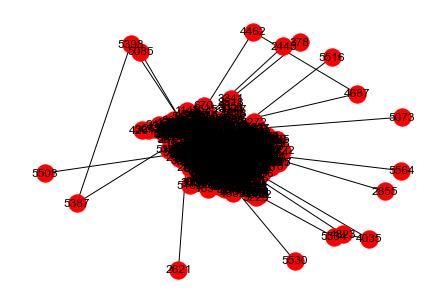

In [12]:
from sklearn.decomposition import PCA
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis

GenresFile = "./data/our_data/normalized_artist_data.csv"
genreData = pd.read_csv(GenresFile)
id_to_name, name_to_id, artist_ids, artist_names, artist_genres = get_artist_names_and_ids(genreData)
genreData = genreData.drop(columns=['artist_name', 'artist_id', 'count', 'popularity', 'genre'])

#只取0.9的有效成分
pca = PCA(n_components=0.9)
artistData_pca = pca.fit_transform(genreData)
artistData_np = np.array(artistData_pca)

'''
distances1 = pairwise_distances(artistData_np, metric='euclidean')
distances2 = pairwise_distances(artistData_np, metric='cosine')
np.savetxt("./data/our_data/distances1.csv", distances1, delimiter=",")
np.savetxt("./data/our_data/distances2.csv", distances2, delimiter=",")
'''
G = nx.Graph()
n = len(artistData_np)

# 计算协方差矩阵和其逆矩阵
cov = LedoitWolf().fit(artistData_np).covariance_
inv_cov = np.linalg.inv(cov)

# 使用马氏距离计算相似度
distances3 = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        diff = artistData_np[i] - artistData_np[j]
        dist = mahalanobis(artistData_np[i], artistData_np[j], inv_cov)
        distances3[i][j] = dist
        distances3[j][i] = dist

np.savetxt("./data/our_data/distances3.csv", distances3, delimiter=",")



for artist_name in artist_names:
    G.add_node(name_to_id[artist_name], name=artist_name)
for i in range(n):
    for j in range(i + 1, n):
        ##similarity1 = distances1[i][j]
        #similarity2 = 2 - distances2[i][j]
        #similarity = similarity1/6 + similarity2
        similarity = distances3[i][j]
        if similarity < sim_seg:  # 设置阈值，只连接相似度高于sim_seg的点
            G.add_edge(artist_ids[i], artist_ids[j], weight=similarity)

# 检查节点是否存在于图中
for i in range(n):
    if i not in G:
        G.add_node(i)
        max_similarity = 0
        max_similarity_node = None
        for j in range(n):
            if i != j and artist_ids[j] in G:
                ##similarity1 = distances1[i][j]
                #similarity2 = 2 - distances2[i][j]
                #similarity = similarity1/6 + similarity2
                similarity = distances3[i][j]
                if similarity > max_similarity:
                    max_similarity = similarity
                    max_similarity_node = j
        if max_similarity_node is not None:
            G.add_edge(artist_ids[i], artist_ids[max_similarity_node], weight=max_similarity)
    elif not any(G.has_edge(artist_ids[i], artist_ids[j]) for j in range(n)):
        # 如果节点i存在于图中，但是与其他节点没有连边，则尝试将其与相似度最大的节点连接
        max_similarity = 0
        max_similarity_node = None
        for j in range(n):
            if i != j and artist_ids[j] in G:
                ##similarity1 = distances1[i][j]
                #similarity2 = 2 - distances2[i][j]
                #similarity = similarity1/6 + similarity2
                similarity = distances3[i][j]
                if similarity > max_similarity:
                    max_similarity = similarity
                    max_similarity_node = j
        if max_similarity_node is not None:
            G.add_edge(artist_ids[i], artist_ids[max_similarity_node], weight=max_similarity)

from networkx.algorithms.components.connected import connected_components
from itertools import combinations
from networkx.algorithms.distance_measures import diameter

# 获取所有连通子图
subgraphs = list(connected_components(G))
print(subgraphs)

# 遍历每个子图
for sg in subgraphs:
    if len(sg) < 10:  # 如果子图节点数量小于10
        max_similarity = 0
        max_similarity_node = None
        for node in sg:
            # 查找与该节点相似度最大的节点
            for other_sg in subgraphs:
                if sg != other_sg and len(other_sg)>10:  # 如果是不同的子图
                    for other_node in other_sg:
                        #similarity1 = distances1[node][other_node]
                        #similarity2 = 2 - distances2[node][other_node]
                        #similarity = similarity1/6 + similarity2
                        similarity = distances3[node][other_node]
                    if similarity > max_similarity:
                        max_similarity = similarity
                        max_similarity_nodes = (node, other_node)

        # 如果相似度超过阈值，则将两个子图相连
        if max_similarity_nodes and max_similarity > 0:
            G.add_edge(artist_ids[max_similarity_nodes[0]], artist_ids[max_similarity_nodes[1]], weight=max_similarity)
# 多次检测，直到成为一个全连通图为止
while len(list(nx.connected_components(G))) > 1:
    # 获取所有连通子图
    subgraphs = list(nx.connected_components(G))
    # 找到相似度最大的两个子图
    max_similarity = 0
    max_similarity_nodes = None
    for i, j in combinations(subgraphs, 2):
        similarity = 0
        for node1 in i:
            for node2 in j:
                #similarity1 = distances1[node1][node2]
                #similarity2 = 2 - distances2[node1][node2]
                #similarity = similarity1/6 + similarity2
                similarity = distances3[node1][node2]
            if similarity > max_similarity:
                max_similarity = similarity
                max_similarity_nodes = (node1, node2)

    # 如果相似度超过阈值，则将两个子图相连
    if max_similarity_nodes and max_similarity > 0:
        G.add_edge(artist_ids[max_similarity_nodes[0]], artist_ids[max_similarity_nodes[1]], weight=max_similarity)

nx.draw(G, with_labels=True, node_color='r')



# 将音乐家的名称存储为一个列表
GenresFile = "./data/our_data/normalized_artist_data.csv"
genreData = pd.read_csv(GenresFile)
artist_names = genreData['artist_name'].tolist()

# 将网络图转化为二元矩阵
adjacency_matrix = np.zeros((len(artist_names), len(artist_names)))
for node1, node2 in G.edges():
    i = artist_names.index(id_to_name[node1])
    j = artist_names.index(id_to_name[node2])
    adjacency_matrix[i][j] = 1
    adjacency_matrix[j][i] = 1

# 将二元矩阵写入CSV文件
df = pd.DataFrame(adjacency_matrix, columns=artist_names, index=artist_names)
df.to_csv('artist_similarity_matrix_pca.csv')



In [15]:
# 计算度分布
degree_dict = dict(G.degree())
degree_distribution = {}
# 找到度数最大的节点
max_degree_node = max(degree_dict, key=degree_dict.get)

# 输出结果
print("度数最大的节点是:", id_to_name[max_degree_node])
'''
for degree in degree_dict.values():
    if degree in degree_distribution:
        degree_distribution[degree] += 1
    else:
        degree_distribution[degree] = 1
print("Degree distribution: ", degree_distribution)

# 计算网络直径
diameter = nx.diameter(G)
print("Network diameter: ", diameter)

# 将度分布保存到CSV文件
with open('degree_distribution.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Degree', 'Frequency'])
    for degree, frequency in degree_distribution.items():
        writer.writerow([degree, frequency])

# 计算网络直径
diameter = nx.diameter(G)

# 将网络直径保存到CSV文件
with open('network_diameter.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Diameter'])
    writer.writerow([diameter])'''

度数最大的节点是: Pete Johnson


'\nfor degree in degree_dict.values():\n    if degree in degree_distribution:\n        degree_distribution[degree] += 1\n    else:\n        degree_distribution[degree] = 1\nprint("Degree distribution: ", degree_distribution)\n\n# 计算网络直径\ndiameter = nx.diameter(G)\nprint("Network diameter: ", diameter)\n\n# 将度分布保存到CSV文件\nwith open(\'degree_distribution.csv\', \'w\', newline=\'\') as file:\n    writer = csv.writer(file)\n    writer.writerow([\'Degree\', \'Frequency\'])\n    for degree, frequency in degree_distribution.items():\n        writer.writerow([degree, frequency])\n\n# 计算网络直径\ndiameter = nx.diameter(G)\n\n# 将网络直径保存到CSV文件\nwith open(\'network_diameter.csv\', \'w\', newline=\'\') as file:\n    writer = csv.writer(file)\n    writer.writerow([\'Diameter\'])\n    writer.writerow([diameter])'

In [148]:
from sklearn.cluster import SpectralClustering



# 使用谱聚类算法进行社区检测
num_clusters = 19  # 设定聚类数目
spectral = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', assign_labels='discretize')
clusters = spectral.fit_predict(adjacency_matrix)

# 获取每个节点所属的社团
communities = []
for i in range(num_clusters):
    communities.append([node for node in G.nodes() if clusters[node] == i])

# 计算每个节点的度数
degree = dict(G.degree())

# 将社团以及社团内节点的度数之和保存到字典中
cluster_degrees = {}
avg_intra = {}
for cluster in range(len(communities)):
    tot_degree = 0
    # 统计社团内节点的度数之和
    cluster_degree = sum(degree[n] for n in communities[cluster])

    # 保存节点所属的社团以及社团内节点的度数之和
    for node in communities[cluster]:
        intra_edges = sum([1 for node1 in G.neighbors(node) if node1 in communities[cluster]])
        cluster_degrees[node] = (cluster, cluster_degree, intra_edges)
        tot_degree += intra_edges
    avg_intra[cluster] = tot_degree/len(communities[cluster])

# 计算每个节点的模块内度和协作系数
z_values = []
p_values = []
for node in G.nodes():
    # 获取节点所属的社团和社团内节点的度数之和
    cluster, cluster_degree, intra_edges = cluster_degrees[node]
    outra_edges = cluster_degree - intra_edges

    # 计算节点在社团内的度数平均值和标准差
    cluster_size = len(communities[cluster])
    cluster_mean_degree = avg_intra[cluster]
    cluster_std_degree = math.sqrt(sum((degree[n] - cluster_mean_degree)**2 for n in communities[cluster]) / cluster_size)

    # 计算节点的模块内度
    z_value = (degree[node] - cluster_mean_degree) / cluster_std_degree
    z_values.append(z_value)

    # 计算节点的协作系数
    neighbor_degrees = {}
    for n in range(len(communities)):
        neighbor_degrees[n] = 0
        for node1 in G.neighbors(node):
            cluster_n, _, _ = cluster_degrees[node1]
            if cluster_n == n:
                neighbor_degrees[n] += 1
    p_value = 1 - sum((neighbor_degrees[k] / degree[node])**2 for k in neighbor_degrees)
    p_values.append(p_value)

# 打印结果
for node in G.nodes():
    print("Node {}: z_value={}, p_value={}".format(node, z_values[node], p_values[node]))

with open('output_cl.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    row = ["name", "z_i", "p_i"]
    csv_writer.writerow(row)
    for i, node in enumerate(G.nodes()):
        row = [id_to_name[node], z_values[i], p_values[i]]
        csv_writer.writerow(row)


# 计算 modularity
def modularity1(G, partition):
    m = G.size(weight='weight')/2
    A = nx.adjacency_matrix(G)
    mod = 0
    for c in set(partition):
        indices = [i for i, x in enumerate(partition) if x == c]
        S = A[indices, :][:, indices]
        lc = S.sum(axis=0)
        dc = np.array(A.sum(axis=0))[0, indices]
        mod += np.sum(S) / (2 * m) - np.sum(dc) * np.sum(lc) / (4 * m ** 2)
    return mod

mod_SC = modularity1(G, clusters)
print("Modularity (LP):", mod_SC)

# 计算 silhouette
silhouette_avg = silhouette_score(adjacency_matrix, clusters)
print("Silhouette score:", silhouette_avg)
'''
# 绘制社区检测结果
pos = nx.spring_layout(G)

color_map = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

colors = [color_map[clusters[i]] for i in range(len(clusters))]
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
'''
# 将节点分类信息添加为节点属性
G2 = G
for i, node in enumerate(G.nodes()):
    G2.nodes[node]['cluster'] = clusters[i]

# 创建一个从节点 ID 到音乐家姓名的映射
id_to_name1 = {node_id: artist_name for node_id, artist_name in enumerate(artist_names)}
# 将节点标识符替换为音乐家姓名
G_renamed = nx.relabel_nodes(G2, id_to_name1)
# 将新图写入 GEXF 文件
nx.write_gexf(G_renamed, "graph_renamed.gexf")


c:\Users\dzk\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Node 0: z_value=-0.08573309639759083, p_value=0.0
Node 1: z_value=-0.4599223400495756, p_value=0.0
Node 2: z_value=0.058185843468557166, p_value=0.1049382716049383
Node 3: z_value=-0.4599223400495756, p_value=0.0
Node 4: z_value=-0.20086824829050923, p_value=0.0
Node 5: z_value=0.2596723592811644, p_value=0.0
Node 6: z_value=0.17332099536147558, p_value=0.0
Node 7: z_value=0.41382044088453257, p_value=0.0
Node 8: z_value=-0.17244092360483973, p_value=0.0
Node 9: z_value=0.0006182675220979691, p_value=0.05709342560553643
Node 10: z_value=0.3460237232008532, p_value=0.12381852551984873
Node 11: z_value=0.02940205549532757, p_value=0.0
Node 12: z_value=-0.8916791596480196, p_value=0.4444444444444444
Node 13: z_value=-0.028939595034769536, p_value=0.0
Node 14: z_value=1.0656184225315932, p_value=0.0
Node 15: z_value=0.9504832706386748, p_value=0.0
Node 16: z_value=-0.22965203626373884, p_value=0.14201183431952646
Node 17: z_value=-0.86289537167479, p_value=0.375
Node 18: z_value=-0.5174899

In [197]:
re_name = 'Irene Cara'
z_filter = [i for i in range(len(G.nodes())) if z_values[i] > 2.5]
for i in z_filter:
    if G2.nodes[i]['cluster'] == 0 and p_values[i] > 0.3:
        print(id_to_name[i])
print(G_renamed.nodes[re_name]['cluster'])
for node in G_renamed.neighbors(re_name):
    print(G_renamed.nodes[node]['cluster'])

Dinah Washington
The Four Freshmen
Oscar D'LeÃ³n
LANY
Terence Blanchard
0
0
0
0
0
0
0
9
0
0
0
0
0
0
0
18
0
0
0
0
0
0
9
0
0
0
0
0
0
0
0
0
0
0
0
0
16
0
0
0
13
0
0
15
0
0
16
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
16
9
0
0
0
0
0
0
0
0
18
0
0
13
0
7
0
0
0
0
16
0
0
16
0
0
12
0
0
0
0
0
0
0
16
4
0
6
0
16
0
0
0
0
0
18
15
0
0
16
18
0
15
16
0
18
0
0
0
0
0
0
0
0
0
0
13
0
0
18
0
0
18
0
18
0
0
0
0
0
18
0
0
18
0
13
16
18
0
0
0
18
0
0
16
0
0
16
0
0
18
18
18
16
0
0
16
18


In [160]:
import cv2

# 读取图片
img = cv2.imread('seg.jpg')



# 在图片上画出直线

cv2.line(img, (120, 445), (1287, 445), (0, 0, 255), 2)
cv2.line(img, (180, 570), (180, 445), (255, 0, 0), 2)   #R1
cv2.line(img, (819, 570), (819, 445), (255, 0, 0), 2)   
cv2.line(img, (1054, 570), (1054, 445), (255, 0, 0), 2) 
cv2.line(img, (470, 28), (470, 445), (0, 255, 0), 2) 
cv2.line(img, (995, 28), (995, 445), (0, 255, 0), 2) 

# 设置文本属性
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
color = (0, 0, 200)
thickness = 2

# 在图片上添加文本
cv2.putText(img, 'R1', (130,515), font, font_scale, color, thickness)
cv2.putText(img, 'R2', (420,515), font, font_scale, color, thickness)
cv2.putText(img, 'R3', (920,515), font, font_scale, color, thickness)
cv2.putText(img, 'R4', (1150,515), font, font_scale, color, thickness)
cv2.putText(img, 'R5', (250,250), font, font_scale, color, thickness)
cv2.putText(img, 'R6', (700,250), font, font_scale, color, thickness)
cv2.putText(img, 'R7', (1120,250), font, font_scale, color, thickness)

# 显示画好直线的图片
cv2.imshow('image', img)
cv2.imwrite('new_image.png', img)
cv2.waitKey(0) 

-1

模块度为: 0.465716716387406


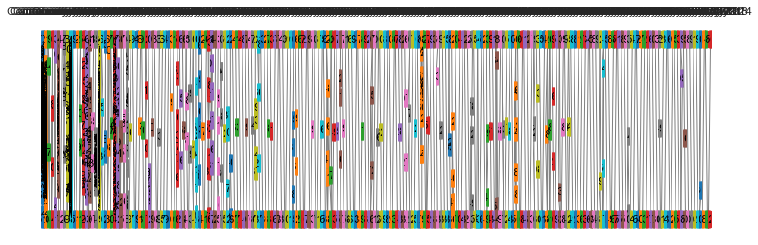

The graph has 214 communities.
平均轮廓系数为 -0.5186288152664736


In [107]:
# 使用Label Propagation算法划分社团
partition = nx.algorithms.community.label_propagation_communities(G)

mod_LP = modularity(G, partition)

print(f"模块度为: {mod_LP}")
# 获取社团数量
num_communities = len(partition)

subgraphs = []
for comm in partition:
    subgraphs.append(G.subgraph(comm))

# 绘制每个子图
fig, axs = plt.subplots(1, len(subgraphs), figsize=(12, 4))
axs = np.array(axs).flatten()
for i, subgraph in enumerate(subgraphs):
    nx.draw(subgraph, ax=axs[i], with_labels=True, node_color=f"C{i}", edge_color='gray')
    axs[i].set_title(f"Community {i+1}")
    # 将网络图转化为二元矩阵
    adjacency_matrix = np.zeros((len(artist_names), len(artist_names)))
    for node1, node2 in subgraph.edges():
        i = artist_names.index(id_to_name[node1])
        j = artist_names.index(id_to_name[node2])
        adjacency_matrix[i][j] = 1
        adjacency_matrix[j][i] = 1

    # 将二元矩阵写入CSV文件
    df = pd.DataFrame(adjacency_matrix, columns=artist_names, index=artist_names)
    df.to_csv('LP{}.csv'.format(i))
    
plt.show()

print("The graph has {} communities.".format(num_communities))
label_dict = {}
for i, comm in enumerate(partition):
    for node in comm:
        label_dict[node] = i
labels = np.array(list(label_dict.values()))

# 计算轮廓系数
sil_LP = sil_score1(G, labels=labels)


模块度为: 0.5086141063410683


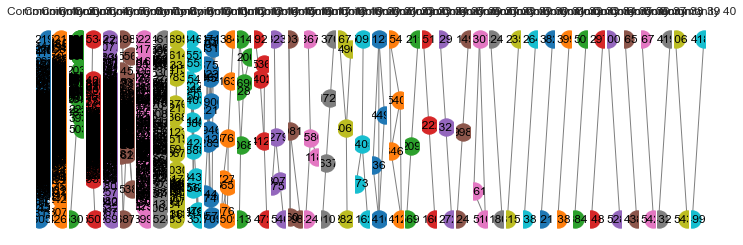

The graph has 40 communities.
平均轮廓系数为 -0.4488598850595076


In [108]:
# 使用Louvain算法划分社团
partition = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)


mod_Lv = modularity(G, partition)

print(f"模块度为: {mod_Lv}")
# 获取社团数量
num_communities = len(partition)

subgraphs = []
for comm in partition:
    subgraphs.append(G.subgraph(comm))

# 绘制每个子图
fig, axs = plt.subplots(1, len(subgraphs), figsize=(12, 4))
axs = np.array(axs).flatten()
for i, subgraph in enumerate(subgraphs):
    nx.draw(subgraph, ax=axs[i], with_labels=True, node_color=f"C{i}", edge_color='gray')
    axs[i].set_title(f"Community {i+1}")
    # 将网络图转化为二元矩阵
    adjacency_matrix = np.zeros((len(artist_names), len(artist_names)))
    for node1, node2 in subgraph.edges():
        i = artist_names.index(id_to_name[node1])
        j = artist_names.index(id_to_name[node2])
        adjacency_matrix[i][j] = 1
        adjacency_matrix[j][i] = 1

    # 将二元矩阵写入CSV文件
    df = pd.DataFrame(adjacency_matrix, columns=artist_names, index=artist_names)
    df.to_csv('Louvain{}.csv'.format(i))
    
plt.show()

print("The graph has {} communities.".format(num_communities))
label_dict = {}
for i, comm in enumerate(partition):
    for node in comm:
        label_dict[node] = i
labels = np.array(list(label_dict.values()))

sil_Lv = sil_score1(G,labels=labels)


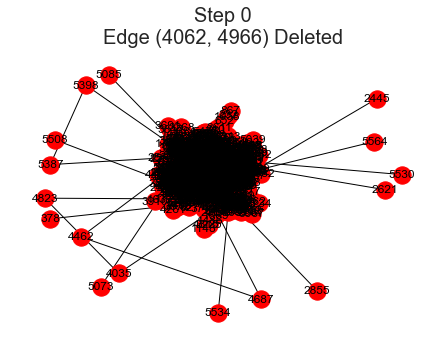

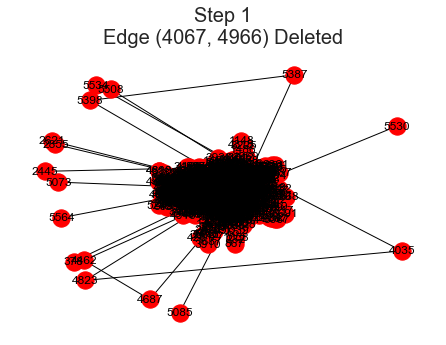

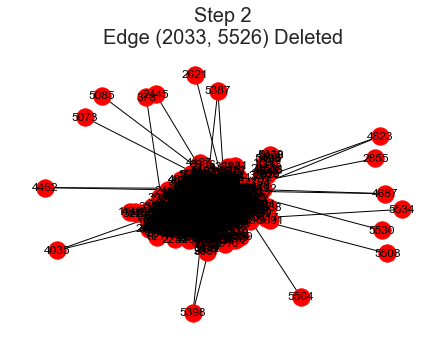

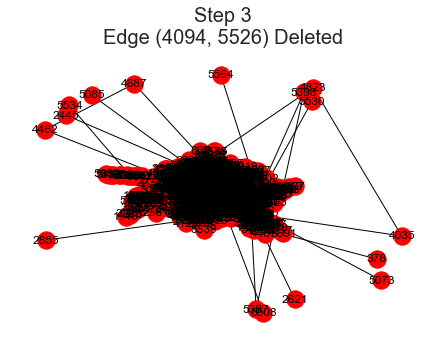

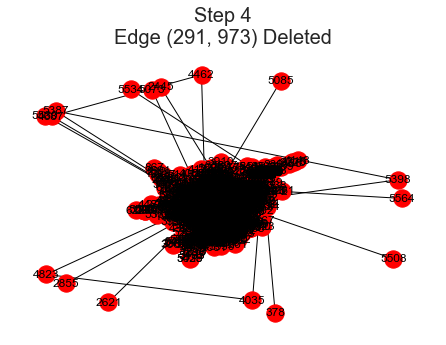

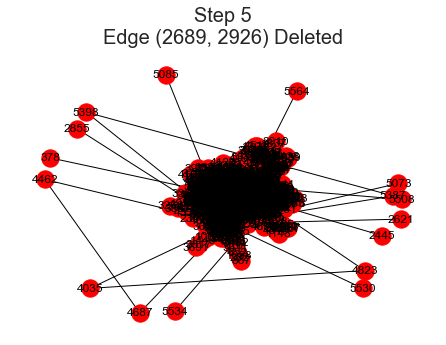

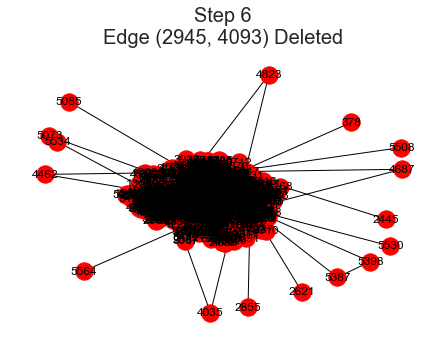

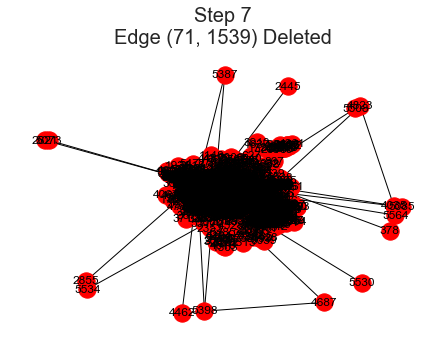

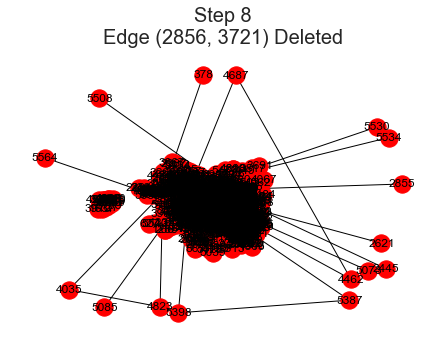

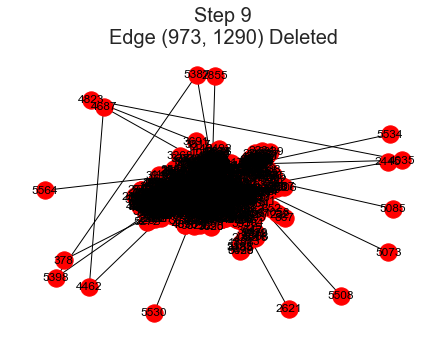

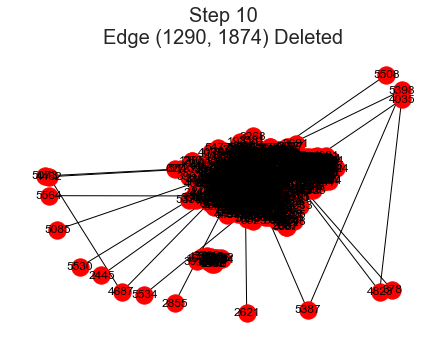

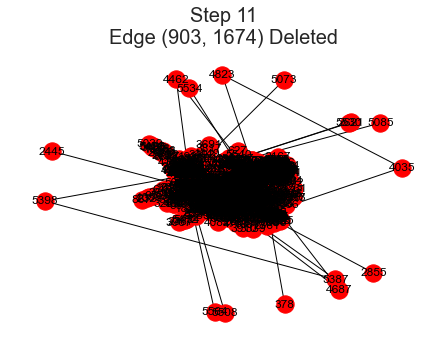

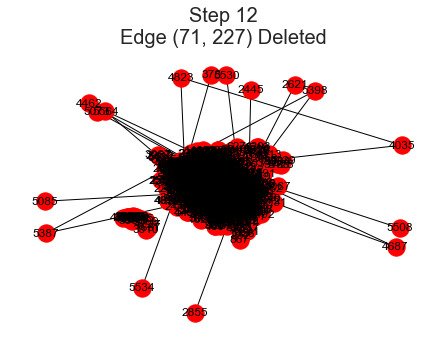

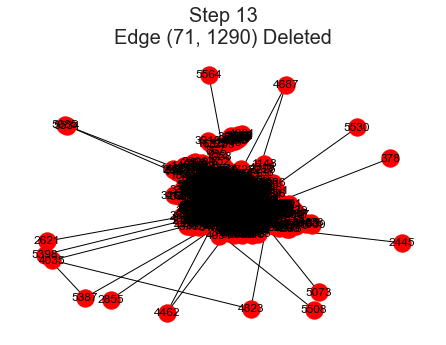

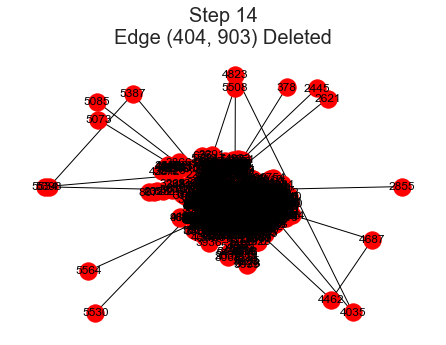

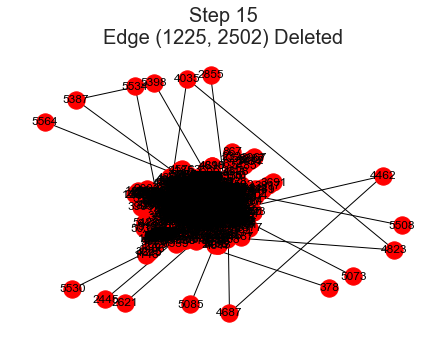

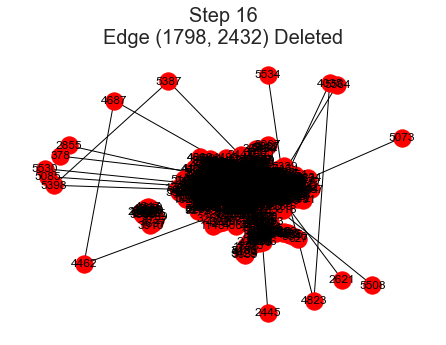

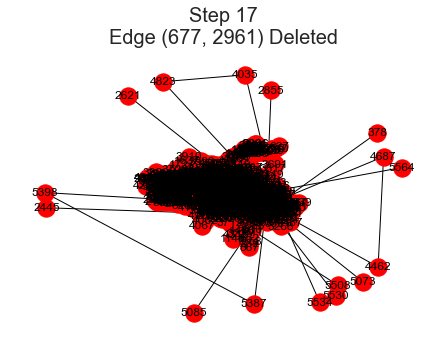

0.31986414502192523
平均轮廓系数为 0.06992719891855863
Accuracy: 0.485183862906105
47 49.33512641204949 51.48491225088241
37 49.33512641204949 51.48491225088241
50 49.33512641204949 51.48491225088241
35 49.33512641204949 51.48491225088241
47 49.33512641204949 51.48491225088241
67 49.33512641204949 51.48491225088241
56 49.33512641204949 51.48491225088241
4 49.33512641204949 51.48491225088241
1 2.0821114369501466 6.053452246849236
46 49.33512641204949 51.48491225088241
67 49.33512641204949 51.48491225088241
67 49.33512641204949 51.48491225088241
7 49.33512641204949 51.48491225088241
2 2.0821114369501466 6.053452246849236
105 49.33512641204949 51.48491225088241
114 49.33512641204949 51.48491225088241
47 49.33512641204949 51.48491225088241
4 49.33512641204949 51.48491225088241
28 49.33512641204949 51.48491225088241
89 49.33512641204949 51.48491225088241
159 49.33512641204949 51.48491225088241
5 7.66796875 7.090590525409251
2 49.33512641204949 51.48491225088241
127 49.33512641204949 51.48491225088

"\ndef compute_community(G):\n    comp = nx.algorithms.community.girvan_newman(G)\n    result = tuple(sorted(c) for c in next(comp))\n    print(result)\n    return result\nif __name__ == '__main__':\n    with concurrent.futures.ThreadPoolExecutor() as executor:\n        future = executor.submit(compute_community, G)\n        result = future.result()\n    with open('./data/our_data/community.csv', mode='w', newline='') as file:\n        writer = csv.writer(file)\n        writer.writerow(['Community'])\n        for row in result:\n            writer.writerow(row)\n"

In [15]:

NUM_ITERATIONS = 18
G1 = G
for i in range(NUM_ITERATIONS):
    edge_betweenness = nx.edge_betweenness_centrality(G1).items()
    edge_to_delete = sorted(edge_betweenness, key=lambda pair: -pair[1])[0][0]
    
    G.remove_edge(*edge_to_delete)

    
    
    nx.draw(G1, with_labels=True, node_color='r')
    plt.title('Step %s\nEdge %s Deleted'%(i, edge_to_delete), fontsize=20)
    plt.show()



# 将网络图转化为二元矩阵
adjacency_matrix = np.zeros((len(artist_names), len(artist_names)))
for node1, node2 in G1.edges():
    i = artist_names.index(id_to_name[node1])
    j = artist_names.index(id_to_name[node2])
    adjacency_matrix[i][j] = 1
    adjacency_matrix[j][i] = 1

# 将二元矩阵写入CSV文件
df = pd.DataFrame(adjacency_matrix, columns=artist_names, index=artist_names)
df.to_csv('GN.csv')

communities = list(nx.connected_components(G1))
mod_GN = modularity(G, communities)
print(mod_GN)
sil_GN = sil_score(G1)

# 预测流派并计算准确率
correct_predictions = 0
for community in nx.connected_components(G1):
    # 统计该社团中出现次数最多的流派
    genre_counts = {}
    for artist_id in community:
        artist_name = id_to_name[artist_id]
        genre = artist_genres[artist_id]
        genre_counts[genre] = genre_counts.get(genre, 0) + 1
    predicted_genre = max(genre_counts, key=genre_counts.get)
    
    # 遍历该社团中的音乐家，计算预测准确数
    for artist_id in community:
        artist_name = id_to_name[artist_id]
        if artist_id in artist_ids and artist_genres[artist_id] == predicted_genre:
            correct_predictions += 1

accuracy = correct_predictions / len(artist_names)
print('Accuracy:', accuracy)

# 计算每个节点的度数
degree = dict(G.degree())

# 将社团以及社团内节点的度数之和保存到字典中
cluster_degrees = {}
avg_intra = {}
for cluster in range(len(communities)):
    tot_degree = 0
    # 统计社团内节点的度数之和
    cluster_degree = sum(degree[n] for n in communities[cluster])

    # 保存节点所属的社团以及社团内节点的度数之和
    for node in communities[cluster]:
        intra_edges = sum([1 for node1 in G.neighbors(node) if node1 in communities[cluster]])
        cluster_degrees[node] = (cluster, cluster_degree, intra_edges)
        tot_degree += intra_edges
    avg_intra[cluster] = tot_degree/len(communities[cluster])




# 计算每个节点的模块内度以及协作系数
z_values = []
p_values = []
for node in G.nodes():
    # 获取节点所属的社团和社团内节点的度数之和
    cluster, cluster_degree, intra_edges = cluster_degrees[node]
    outra_edges = cluster_degree - intra_edges

    
    # 计算节点在社团内的度数平均值和标准差
    cluster_size = len(communities[cluster])
    cluster_mean_degree = avg_intra[cluster]
    cluster_std_degree = math.sqrt(sum((degree[n] - cluster_mean_degree)**2 for n in communities[cluster]) / cluster_size)
    
    # 计算节点的模块内度
    z_value = (degree[node] - cluster_mean_degree) / cluster_std_degree
    print(degree[node], cluster_mean_degree, cluster_std_degree)
    z_values.append(z_value)
    
    # 计算节点的协作系数
    neighbor_degrees = {}
    for n in range(len(communities)):
        neighbor_degrees[n] = 0
        for node1 in G.neighbors(node):
            cluster_n, _, _ = cluster_degrees[node1]
            if cluster_n == n:
                neighbor_degrees[n] += 1
    p_value = 1 - sum((neighbor_degrees[k] / degree[node])**2 for k in neighbor_degrees)
    p_values.append(p_value)
    
# 输出每个节点的模块内度和协作系数
for i, node in enumerate(G.nodes()):
    print(f"{node}: z = {z_values[i]}, p = {p_values[i]}")
with open('output.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    row = ["name", "z_i", "p_i"]
    csv_writer.writerow(row)
    for i, node in enumerate(G.nodes()):
        row = [id_to_name[node], z_values[i], p_values[i]]
        csv_writer.writerow(row)





#print(compute_genre_community_accuracy('./res/artistData_concated1.csv','./data/our_data/community.csv'))
'''
import csv
# 使用Girvan-Newman算法检测社区结构
comp = nx.algorithms.community.girvan_newman(G)

# 获取社区列表
result = tuple(sorted(c) for c in next(comp))

# 将结果输出到CSV文件
with open('./data/our_data/community.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Community'])
    for row in result:
        writer.writerow(row)

'''
'''
def compute_community(G):
    comp = nx.algorithms.community.girvan_newman(G)
    result = tuple(sorted(c) for c in next(comp))
    print(result)
    return result
if __name__ == '__main__':
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future = executor.submit(compute_community, G)
        result = future.result()
    with open('./data/our_data/community.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Community'])
        for row in result:
            writer.writerow(row)
'''


In [137]:
'''
# 使用Girvan-Newman算法检测社区结构
comp = nx.algorithms.community.girvan_newman(G)


# 获取社区列表
communities = tuple(sorted(c) for c in next(comp))
# 计算每个节点的度数
degree = dict(G.degree())

# 计算每个节点所属社区的社区内节点度数之和
cluster_degrees = {}
avg_intra = {}
for cluster in range(len(communities)):
    tot_degree = 0
    # 统计社区内节点的度数之和
    cluster_degree = sum(degree[n] for n in communities[cluster])

    # 保存节点所属的社区以及社区内节点的度数之和
    for node in communities[cluster]:
        intra_edges = sum([1 for node1 in G.neighbors(node) if node1 in communities[cluster]])
        cluster_degrees[node] = (cluster, cluster_degree, intra_edges)
        tot_degree += intra_edges
    avg_intra[cluster] = tot_degree/len(communities[cluster])

# 计算每个节点的模块内度以及协作系数
z_values = []
p_values = []
for node in G.nodes():
    # 获取节点所属的社区和社区内节点的度数之和
    cluster, cluster_degree, intra_edges = cluster_degrees[node]
    outra_edges = cluster_degree - intra_edges
    
    # 计算节点在社区内的度数平均值和标准差
    cluster_size = len(communities[cluster])
    cluster_mean_degree = avg_intra[cluster]
    cluster_std_degree = math.sqrt(sum((degree[n] - cluster_mean_degree)**2 for n in communities[cluster]) / cluster_size)
    
    # 计算节点的模块内度
    z_value = (degree[node] - cluster_mean_degree) / cluster_std_degree
    z_values.append(z_value)
    
    # 计算节点的协作系数
    neighbor_degrees = {}
    for n in range(len(communities)):
        neighbor_degrees[n] = 0
    for node1 in G.neighbors(node):
        cluster_n, _, _ = cluster_degrees[node1]
        if cluster_n == cluster:
            neighbor_degrees[cluster] += 1
    p_value = 1 - sum((k / degree[node])**2 for k in neighbor_degrees)

    p_values.append(p_value)
    
# 输出每个节点的模块内度和协作系数
with open('output1.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    row = ["name", "z_i", "p_i"]
    csv_writer.writerow(row)
    for i, node in enumerate(G.nodes()):
        row = [node, z_values[i], p_values[i]]
        csv_writer.writerow(row)
'''

In [180]:
# 计算每个节点的度数
degree = dict(G.degree())

# 将社团以及社团内节点的度数之和保存到字典中
cluster_degrees = {}
avg_intra = {}
for cluster in range(len(communities)):
    tot_degree = 0
    # 统计社团内节点的度数之和
    cluster_degree = sum(degree[n] for n in communities[cluster])

    # 保存节点所属的社团以及社团内节点的度数之和
    for node in communities[cluster]:
        intra_edges = sum([1 for node1 in G1.neighbors(node) if node1 in communities[cluster]])
        cluster_degrees[node] = (cluster, cluster_degree, intra_edges)
        tot_degree += intra_edges
    avg_intra[cluster] = tot_degree/len(communities[cluster])
    print(avg_intra[cluster])




# 计算每个节点的模块内度以及协作系数
z_values = []
p_values = []
for node in G.nodes():
    # 获取节点所属的社团和社团内节点的度数之和
    cluster, cluster_degree, intra_edges = cluster_degrees[node]
    outra_edges = cluster_degree - intra_edges

    
    # 计算节点在社团内的度数平均值和标准差
    cluster_size = len(communities[cluster])
    cluster_mean_degree = avg_intra[cluster]
    cluster_std_degree = math.sqrt(sum((degree[n] - cluster_mean_degree)**2 for n in communities[cluster]) / cluster_size)
    
    # 计算节点的模块内度
    z_value = (degree[node] - cluster_mean_degree) / cluster_std_degree

    z_values.append(z_value)
    
    # 计算节点的协作系数
    neighbor_degrees = {}
    #for n in range(len(communities)):
    neighbor_degrees[0] = 0
    neighbor_degrees[1] = 0
    neighbor_degrees[2] = 0
    neighbor_degrees[3] = 0
    for node1 in G.neighbors(node):
        cluster_n, a, b = cluster_degrees[node1]
            

        if cluster_n == 0:
            neighbor_degrees[0] += 1
        if cluster_n == 1:
            neighbor_degrees[1] += 1
        if cluster_n == 2:
            neighbor_degrees[2] += 1
        if cluster_n == 3:
            neighbor_degrees[3] += 1

                
    if(sum(k for k in neighbor_degrees) != degree[node]):  
        print(sum((neighbor_degrees[k]/degree[node])**2 for k in neighbor_degrees), degree[node]) 
    #p_value = 1 - sum((k / degree[node])**2 for k in neighbor_degrees)
    p_value = 1 - sum((neighbor_degrees[k] / degree[node])**2 for k in neighbor_degrees)
    '''
    for k in range(len(communities)):
        p_value = p_value - (neighbor_degrees[k]/degree[node])**2
    '''



    p_values.append(p_value)
    
# 输出每个节点的模块内度和协作系数
for i, node in enumerate(G.nodes()):
    print(f"{node}: z = {z_values[i]}, p = {p_values[i]}")
with open('output2.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    row = ["name", "z_i", "p_i"]
    csv_writer.writerow(row)
    for i, node in enumerate(G.nodes()):
        row = [id_to_name[node], z_values[i], p_values[i]]
        csv_writer.writerow(row)





70.18686868686869
10.110032362459547
1.9972489683631363
2.101010101010101
1.0 67
1.0 62
1.0 72
1.0 58
1.0 71
1.0 102
1.0 75
1.0 5
1.0 3
1.0 62
1.0 89
1.0 108
1.0 17
1.0 3
1.0 147
1.0 166
1.0 84
1.0 47
1.0 122
1.0 225
1.0 10
1.0 3
1.0 197
1.0 165
1.0 14
1.0 3
1.0 13
1.0 153
1.0 8
1.0 1
1.0 90
1.0 213
1.0 153
1.0 289
1.0 115
1.0 63
1.0 107
1.0 40
1.0 252
1.0 207
1.0 1
1.0 248
1.0 116
1.0 146
1.0 39
1.0 35
1.0 40
1.0 9
1.0 42
1.0 87
1.0 264
1.0 168
1.0 10
1.0 48
1.0 36
1.0 1
1.0 154
1.0 168
1.0 21
1.0 55
1.0 2
1.0 52
1.0 129
1.0 134
1.0 93
1.0 8
1.0 126
1.0 14
1.0 15
1.0 111
1.0 45
1.0 9
1.0 91
1.0 40
1.0 21
1.0 18
1.0 96
1.0 160
1.0 13
1.0 168
1.0 242
1.0 86
1.0 80
1.0 58
1.0 174
1.0 164
1.0 188
1.0 7
1.0 8
1.0 70
1.0 128
1.0 188
1.0 135
1.0 45
1.0 1
1.0 194
1.0 132
1.0 96
1.0 17
1.0 116
1.0 13
1.0 46
1.0 115
1.0 132
1.0 351
1.0 106
1.0 19
1.0 142
1.0 54
1.0 125
1.0 18
1.0 346
1.0 2
1.0 210
1.0 67
1.0 59
1.0 251
1.0 9
1.0 25
1.0 226
1.0 29
1.0 46
1.0 325
1.0 99
1.0 84
1.0 52
1.0 118
1.0 

In [110]:
def compute_genre_community_accuracy(artist_file_path, community_file_path):
    # 读取艺术家数据
    artist_data = pd.read_csv(artist_file_path)
    artist_data = cleanData(artist_data)
    # 构建图
    G = nx.Graph()
    genre_res = pd.DataFrame(index=artist_data.index, columns=['genre'])

    for row_index, row in artist_data['artist_name'].items():
        G.add_node(row, genre=artist_data['genre'][row_index])


    # 读取社团数据
    with open(community_file_path, mode='r') as file:
        reader = csv.reader(file)
        communities = [set(row) for row in reader]

    # 比较社团和真实数据的genre
    total_artists = len(artist_data)
    correct_artist_count = 0
    for community in communities:
        genre_count = {}
        for artist_name in community:
            artist_genre_series = artist_data.loc[artist_data['artist_name'] == artist_name]['genre']
            if not artist_genre_series.empty:
                artist_genre = artist_genre_series.iloc[0]
                if artist_genre in genre_count:
                    genre_count[artist_genre] += 1
                else:
                    genre_count[artist_genre] = 1
        # 找到数量最多的genre
        if genre_count:
            most_common_genre = max(genre_count, key=genre_count.get)
        # 检查社团中所有艺术家的genre是否与最多的genre相同
        for artist_name in community:
            artist_genre_series = artist_data.loc[artist_data['artist_name'] == artist_name]['genre']
            if not artist_genre_series.empty:
                artist_genre = artist_genre_series.iloc[0]
                if artist_genre == most_common_genre:
                    correct_artist_count += 1

    # 计算准确率
    accuracy = correct_artist_count / total_artists

    return accuracy

acc = compute_genre_community_accuracy('./res/artistData_concated1.csv','./data/our_data/community.csv')
print(acc)

0.0003570153516601214


In [111]:
def save_graph(G, num):
    # 读取 artistData_concated1.csv
    artists = {}
    with open('./res/artistData_concated1.csv', mode='r') as file:
        reader = csv.DictReader(file, delimiter='\t')
        for row in reader:
            artist_id = int(row['artist_id'])
            artists[artist_id] = {
                'name': row['artist_name'],
                'genre': row['genre']
            }

    # 构建图
    G = nx.Graph()
    for _, row in artist_data.iterrows():
        artist_id = row['id']
        G.add_node(artist_id, label=artist_id, name=artists[artist_id]['name'])
        G.nodes[artist_id]['genre'] = artists[artist_id]['genre']

    # 将图保存为 Gephi 的 GEXF 格式，包括节点的 label、name、genre 信息
    nx.write_gexf(G, './output/graph{}.gexf'.format(num))


In [112]:
# 打开CSV文件并将输出值追加到末尾
with open('modularity.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([sim_seg, mod_LP, mod_Lv, mod_GN])

# 打开CSV文件并将输出值追加到末尾
with open('silhoouette.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([sim_seg, sil_LP, sil_Lv, sil_GN])